In [1]:
import pandas as pd
import numpy as np
import copy

# Web scraper task
Here is the part where you modify the cells. Modify the range of pages in the first for loop, the keyword to signal comment extraction (if necessary), and the target language for translation (if necessary) 

In [2]:
import time
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

directory_of_chromedriver=r"C:\Users\celin\Documents\chromedriver.exe"

In [21]:
# Котлеты домашние из растительного мяса, Welldone, 180 г 491037254
# Котлеты для бургеров из растительного мяса, Welldone, 200 г 491165096
# Фарш из растительного мяса, Welldone, 400 г 491083590
# Котлеты растительные Hiburger для бургера Hi, 800 г 229186105
# Наггетсы растительные Hi - Higgets, замороженные, 200 г 317602877
# Филе растительное со вкусом говядины Hi 200г, 400 г 626538288
res = []
product_id = 626538288
for i in range(1,9):
    attempt_counter = 0
    result = False
    while attempt_counter < 5 and not result:
        try:
            driver = webdriver.Chrome(executable_path=directory_of_chromedriver)
            driver.get(f'https://www.ozon.ru/product/{product_id}/reviews?page={i}')
            
            review_elements = driver.find_elements(By.XPATH, '//div[@class="sq"]')
            rating_elements = driver.find_elements(By.XPATH, '//div[@class="e1-a6"]')
            
            for review, rating_element in zip(review_elements, rating_elements):
                review_text = review.text.splitlines()
                style_value = rating_element.get_attribute("style")
                rating = int(style_value.replace('width:', '').replace('%;', ''))/20   # Assuming 100% corresponds to 5 stars, 80% corresponds to 4 stars, etc.
                
                res.append((review_text, rating))
            
            driver.close()
            result = True
        except NoSuchElementException:
            print(f'Page {i}: Error N{attempt_counter+1}')
            attempt_counter += 1
            driver.close()
            
    if attempt_counter == 5:
        print(f'Error on page {i}')


C:\Users\celin\AppData\Local\Temp\ipykernel_18888\3279653217.py:14: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=directory_of_chromedriver)


In [ ]:
# Create a dictionary with product IDs as keys and brand names as values
brands = {491037254: 'Welldone', 
          491165096: 'Welldone', 
          491083590: 'Welldone', 
          229186105: 'Healthy Innovation', 
          317602877: 'Healthy Innovation', 
          626538288: 'Healthy Innovation'}

# Create a new column 'Brand' in your dataframe by applying a lambda function to each row
# Assume df is your dataframe and 'Product_ID' is the column with the product IDs
df['Brand'] = df['Product_ID'].apply(lambda x: brands[x] if x in brands else 'Unknown')


In [23]:
# copy data
data = res.copy() 

# extract information
data_extracted = []

for item in data:
    review = item[0]
    rating = item[1]
    
    try:
        name_index = review.index('Товар куплен на OZON') - 2
        name = review[name_index]
    except ValueError:
        date = None

    try:
        date_index = review.index('Товар куплен на OZON') - 1
        date = review[date_index]
    except ValueError:
        date = None

    try:
        advantages_index = review.index('Достоинства') + 1
        advantages = review[advantages_index]
    except ValueError:
        advantages = None
    
    try:
        disadvantages_index = review.index('Недостатки') + 1
        disadvantages = review[disadvantages_index]
    except ValueError:
        disadvantages = None
    
    try:
        comment_index = review.index('Комментарий') + 1
        comment = review[comment_index]
    except ValueError:
        comment = None
    
    data_extracted.append((product_id, name, date, advantages, disadvantages, comment, rating))


df = pd.DataFrame(data_extracted, columns=['product_id', 'name', 'date', 'advantages', 'disadvantages', 'comment', 'rating'])

print(df)


     product_id                                       name           date   
0     626538288                                  Венера К.  7 Апреля 2023  \
1     626538288                                   Мария Г.    24 Мая 2023   
2     626538288                                   Ирада А.    21 Мая 2023   
3     626538288  Пользователь предпочёл скрыть свои данные     2 Мая 2023   
4     626538288                                   Олеся П.  2 Апреля 2023   
..          ...                                        ...            ...   
160   626538288  Пользователь предпочёл скрыть свои данные   22 Июля 2022   
161   626538288                                 Виталий Г.   16 Июля 2022   
162   626538288                                 Виталий Г.   16 Июля 2022   
163   626538288  Пользователь предпочёл скрыть свои данные   16 Июля 2022   
164   626538288                               Анастасия Ц.   14 Июля 2022   

           advantages                                      disadvantages   

In [61]:
df.to_csv('combined_reviews.csv', mode='a', header=True, encoding='utf-8-sig')

In [48]:
#Alternative to translate comment, if the amount of request is too big
from yandexfreetranslate import YandexFreeTranslate
yt = YandexFreeTranslate(api = "ios")
chunk_size = 1000 # number of rows to translate per chunk

for i in range(0, len(df), chunk_size):
    start = i
    end = min(i + chunk_size, len(df))
    print(f"Translating rows {start+1} to {end}...")

    # translate the current chunk of rows
    df_test.loc[start:end, "advantages_en"] = df_test.loc[start:end, "advantages"].apply(lambda x: yt.translate('ru','en',
                x) if type(x) == str else x)

Translating rows 1 to 1000...


KeyboardInterrupt: 

# Sentiment analysis tasks

In [283]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Download the stop words and wordnet from NLTK
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text
    word_tokens = word_tokenize(text)

    # Lowercase each word in the text
    word_tokens = [word.lower() for word in word_tokens]

    # Remove punctuation and numbers
    word_tokens = [re.sub('[^a-zA-Z]', '', word) for word in word_tokens]

    # Lemmatize and remove stop words
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words and word != ""]

    return " ".join(word_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [288]:
from tqdm import tqdm

# Then modify your apply calls like this:
tqdm.pandas()

# Apply the preprocessing function to your text data, handling missing values
df['advantages_processed'] = df['advantages'].fillna('').apply(preprocess_text)
df['disadvantages_processed'] = df['disadvantages'].fillna('').apply(preprocess_text)
df['comment_processed'] = df['comment'].fillna('').apply(preprocess_text)

In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate all preprocessed reviews into one column
df['all_reviews_processed'] = df['advantages_processed'] + ' ' + df['disadvantages_processed'] + ' ' + df['comment_processed']

# Instantiate the vectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(df['all_reviews_processed'])

# This matrix can then be used for further analysis (sentiment analysis, topic modeling, etc.)


In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Create a SentimentIntensityAnalyzer object
sid_obj = SentimentIntensityAnalyzer()

df['all_reviews'] = df['all_reviews'].fillna('')
# Prepare columns for sentiment scores
df['vader_score'] = 0.0
df['textblob_score'] = 0.0

# Function to get sentiment score using VADER
def get_vader_score(text):
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict['compound']

# Function to get sentiment score using TextBlob
def get_textblob_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the functions to the reviews
df['vader_score'] = df['all_reviews'].apply(get_vader_score)
df['textblob_score'] = df['all_reviews'].apply(get_textblob_score)


In [294]:
columns = ['advantages_processed','disadvantages_processed', 'comment_processed']
df = df.drop(columns=columns)

In [94]:
# Prepare the dataset for sentiment analysis (remove NaN)
df = pd.read_csv('combined_reviews_translated.csv')
df = df.drop(columns='Unnamed: 0')
df['advantages'] = df['advantages'].fillna('')
df['disadvantages'] = df['disadvantages'].fillna('')
df['comment'] = df['comment'].fillna('')


In [95]:
from transformers import pipeline
from tqdm import tqdm

# Get RoBERTa model
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
#If you get "The size of tensor a (707) must match the size of tensor b (512)" you need to change padding
#classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None, truncation=True,max_length=50,add_special_tokens=True,padding=True)

# with pd.option_context('display.max_colwidth', None):
#   display(df.loc[1,:])

# Concatenate all preprocessed reviews into one column
df['all_reviews'] = df['advantages'] + ' ' + df['disadvantages'] + ' ' + df['comment']

# Initialize an empty list to store the results
sentiments = []

# Iterate over the reviews with a progress bar from tqdm
for review in tqdm(df['all_reviews']):
    try:
        # Classify the sentiment of the review and append it to our list
        sentiment = classifier(review)
        sentiments.append(sentiment)
    except Exception as e:
        # If there's any error, append a None to our list and print the error message
        sentiments.append(None)
        print(f"Error: {e}, at: {review}")

# Assign the list of sentiments to a new column in the dataframe
df["sentiments"] = sentiments

c:\Users\celin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 1030/1030 [00:36<00:00, 27.96it/s]


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

df['all_reviews'] = df['all_reviews'].fillna('')

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

sentiment_labels = []
sentiment_scores = []

for text in df['all_reviews']:
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    
    sentiment_labels.append([config.id2label[label_id] for label_id in ranking])
    sentiment_scores.append(scores[ranking])

# Save sentiment labels and scores in separate columns
df[['negative', 'neutral', 'positive']] = pd.DataFrame(sentiment_scores, columns=['s_negative', 's_neutral', 's_positive'])
df[['Label1', 'Label2', 'Label3']] = pd.DataFrame(sentiment_labels, columns=['Label1', 'Label2', 'Label3'])
columns = ['Label1', 'Label2', 'Label3']
df = df.drop(columns=columns)


In [ ]:
# Normalize json in 'BERT_emotions' into separate columns and add to the original dataframe
df_emotions = pd.json_normalize(df['BERT_emotions'].apply(lambda x: x[0]))

# Merge it with the original dataframe
df = pd.concat([df, df_emotions], axis=1)
# Function to extract emotions
def extract_emotions(emotion_list):
    # Flatten the list of dictionaries
    emotion_dict = {emotion['label']: emotion['score'] for emotion in emotion_list[0]}
    return pd.Series(emotion_dict)

# Apply the function to each row of 'BERT_emotions'
emotions_df = df['BERT_emotions'].apply(extract_emotions)

# Join the original DataFrame with the new DataFrame
df = df.join(emotions_df)

In [169]:
# Save DataFrame to .csv with UTF-8 encoding
df.to_csv('bert_reviews_final.csv', index=False, encoding='utf-8')
# Load DataFrame from .csv with UTF-8 encoding
df = pd.read_csv('bert_reviews_final.csv', encoding='utf-8')

In [141]:
df.to_excel('abert_reviews_final.xlsx', index=False)

# Exploratory Descriptive Statistics

In [456]:
#Manual verification of false positive, false negative and inaccurate emotion score (empty reviews)
df = pd.read_excel('abert_final_sentiment.xlsx')
df.columns

Index(['product_id', 'brand', 'name', 'date', 'advantages', 'disadvantages',
       'comment', 'all_reviews', 'rating', 'anger', 'disgust', 'fear', 'joy',
       'neutral', 'sadness', 'surprise', 'vader_score', 'textblob_score',
       'BERT_sentiments', 's_positive', 's_neutral', 's_negative'],
      dtype='object')

In [457]:
# Create a dataframe for the brand "Welldone"
df_welldone = df[df['brand'] == 'Welldone']
# Create a dataframe for the brand "Healthy Innovation"
df_hi = df[df['brand'] == 'Healthy Innovation']

In [458]:
# Descriptive statistics
table_stat = round(df.describe(),2)
table_stat

,product_id,date,rating,anger,disgust,fear,joy,neutral,sadness,surprise,vader_score,textblob_score,s_positive,s_neutral,s_negative
count,6.730000e+02,673,673.00,673.00,673.00,673.00,673.00,673.00,673.00,673.00,673.00,673.00,673.00,673.00,673.00
mean,4.462690e+08,2021-12-30 18:51:53.224368384,3.26,0.12,0.12,0.12,0.39,0.52,0.02,0.27,0.07,0.04,0.48,0.46,0.50
min,2.291861e+08,2021-01-01 00:00:00,1.00,0.11,0.11,0.11,0.10,0.46,0.01,0.01,-1.00,-1.12,0.00,0.00,0.00
25%,3.176029e+08,2021-07-01 00:00:00,2.00,0.11,0.11,0.11,0.12,0.50,0.02,0.02,-0.17,-0.24,0.24,0.22,0.27
50%,4.910836e+08,2022-01-06 00:00:00,3.00,0.12,0.12,0.12,0.13,0.50,0.02,0.02,0.09,0.05,0.47,0.44,0.49
75%,4.911651e+08,2022-06-30 00:00:00,5.00,0.12,0.12,0.12,0.93,0.54,0.02,0.93,0.41,0.39,0.72,0.69,0.72
max,6.265383e+08,2022-12-31 00:00:00,5.00,0.13,0.13,0.13,0.96,0.94,0.32,0.96,1.00,1.00,1.00,1.00,1.00
std,1.267999e+08,NaN,1.42,0.01,0.01,0.01,0.37,0.03,0.01,0.41,0.44,0.44,0.29,0.28,0.27


In [503]:
# Summary statistics
import pandas as pd

def compute_summary_statistics(df_name):
    df = globals()[df_name]  # Access the dataframe using its name
    
    # Calculate the summary statistics
    rating_mean = round(df['rating'].mean(), 2)
    rating_std = round(df['rating'].std(), 2)
    vader_mean = round(df['vader_score'].mean(), 2)
    vader_std = round(df['vader_score'].std(), 2)
    textblob_mean = round(df['textblob_score'].mean(), 2)
    textblob_std = round(df['textblob_score'].std(), 2)
    
    # Create the summary statistics dataframe
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Standard Deviation'],
        'Rating': [rating_mean, rating_std],
        'VADER Score': [vader_mean, vader_std],
        'TextBlob Score': [textblob_mean, textblob_std]
    })
    
    return summary_stats

# Example usage:
print("summary stats all")
df_name = 'df'
summary_statistics = compute_summary_statistics(df_name)
print(summary_statistics)
print("summary stats welldone")
df_name = 'df_welldone'
summary_statistics = compute_summary_statistics(df_name)
print(summary_statistics)
print("summary stats hi")
df_name = 'df_hi'
summary_statistics = compute_summary_statistics(df_name)
print(summary_statistics)

summary stats all
            Statistic  Rating  VADER Score  TextBlob Score
0                Mean    3.26         0.07            0.04
1  Standard Deviation    1.42         0.44            0.44
summary stats welldone
            Statistic  Rating  VADER Score  TextBlob Score
0                Mean    3.46         0.14            0.12
1  Standard Deviation    1.46         0.44            0.46
summary stats hi
            Statistic  Rating  VADER Score  TextBlob Score
0                Mean    3.02        -0.01           -0.05
1  Standard Deviation    1.34         0.41            0.40


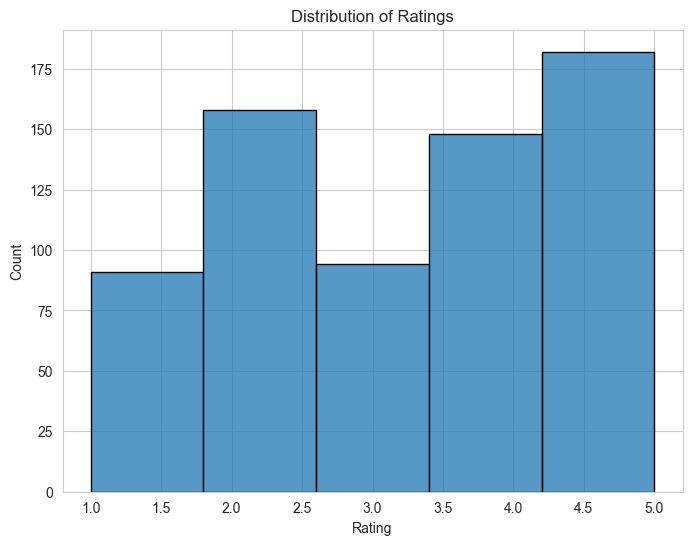

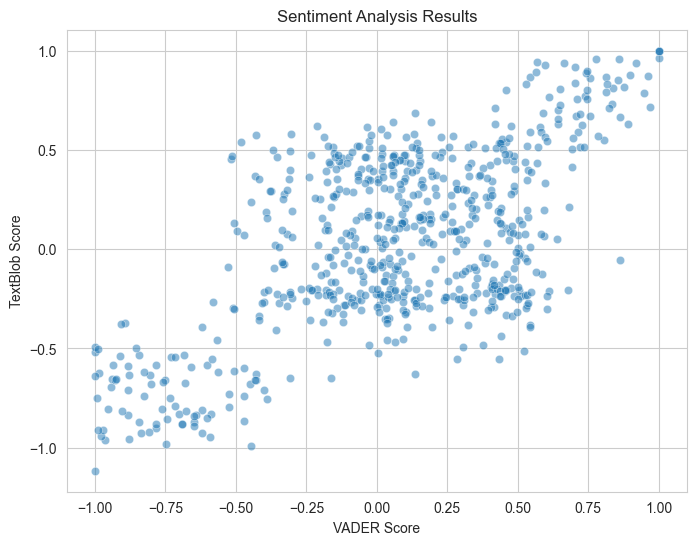

In [460]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and context for seaborn
sns.set_style('whitegrid')

# Figure 1: Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='rating', bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.savefig('ratings_histogram.png')
plt.show()

# Figure 2: Sentiment Analysis Results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='vader_score', y='textblob_score', alpha=0.5)
plt.xlabel('VADER Score')
plt.ylabel('TextBlob Score')
plt.title('Sentiment Analysis Results')
plt.savefig('sentiment_scatterplot.png')
plt.show()

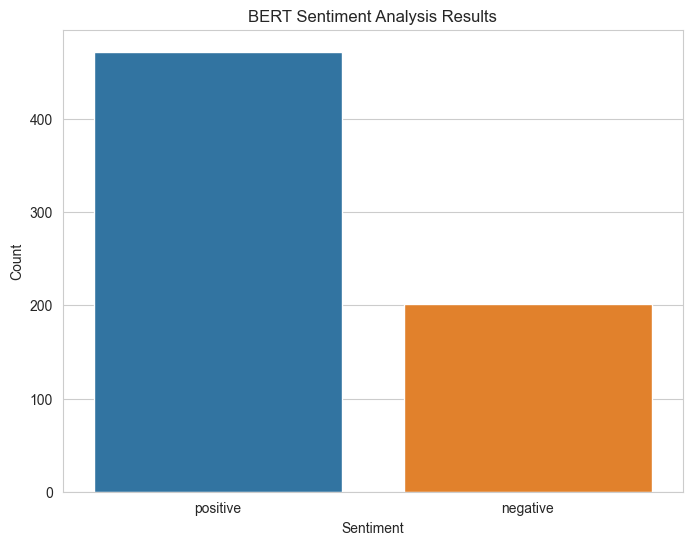

In [461]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and context for seaborn
sns.set_style('whitegrid')

# Calculate the count of positive and negative sentiments
sentiment_counts = df['BERT_sentiments'].value_counts()

# Figure 3: BERT Sentiment Analysis Results
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('BERT Sentiment Analysis Results')
plt.savefig('bert_sentiment_barplot.png')
plt.show()

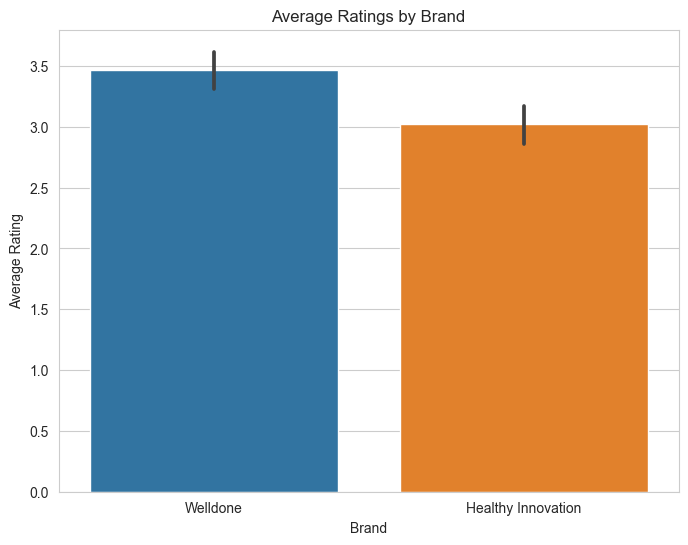

In [462]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style and context for seaborn
sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.barplot(x='brand', y='rating', data=df)
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Brand')
plt.xticks(rotation=0)
plt.savefig('average_ratings_barplot.png')
plt.show()


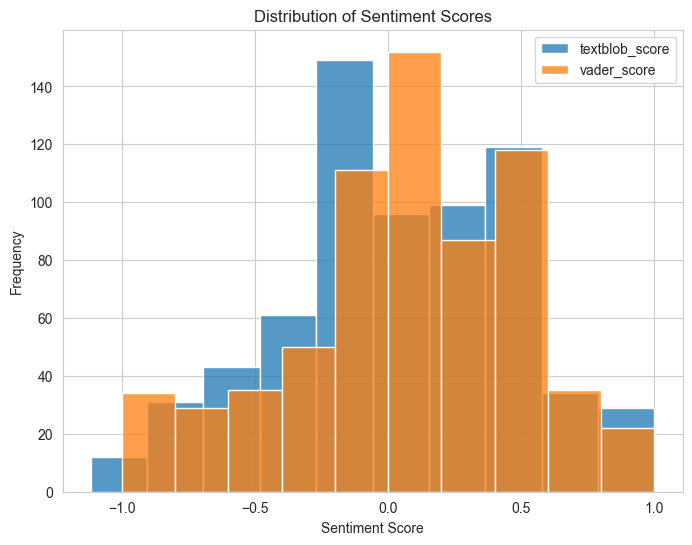

In [463]:
import seaborn as sns

# Set style and context for seaborn
sns.set_style('whitegrid')

# Plot histogram for 'textblob_score' and 'vader_score'
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='textblob_score', bins=10, label='textblob_score')
sns.histplot(data=df, x='vader_score', bins=10, label='vader_score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.show()

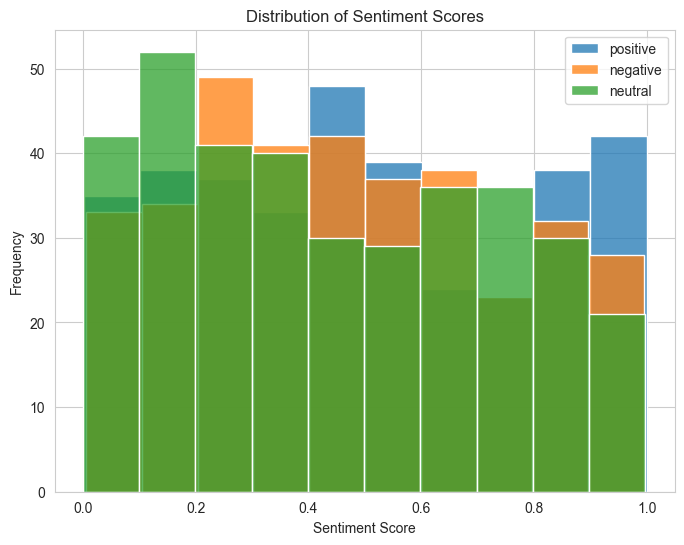

In [464]:
import seaborn as sns

# Set style and context for seaborn
sns.set_style('whitegrid')

# Plot histogram for positive, neutral and negative scores
plt.figure(figsize=(8, 6))
sns.histplot(data=df_welldone, x='s_positive', bins=10, label='positive')
sns.histplot(data=df_welldone, x='s_negative', bins=10, label='negative')
sns.histplot(data=df_welldone, x='s_neutral', bins=10, label='neutral')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.show()

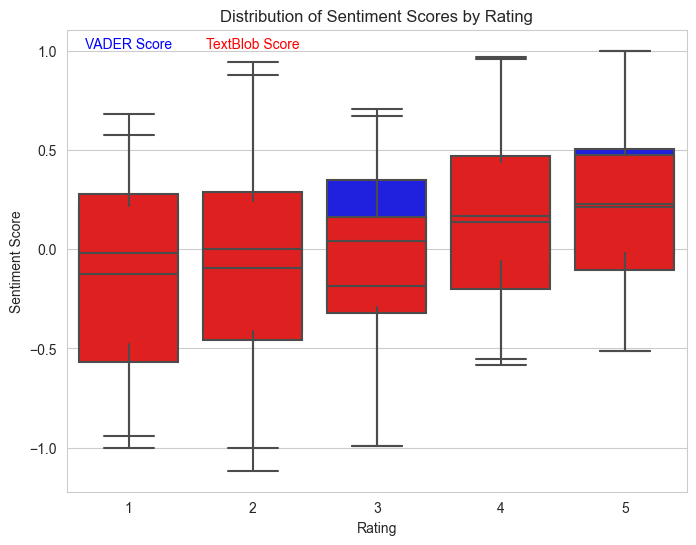

In [465]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='rating', y='vader_score', color='blue', showfliers=False)
sns.boxplot(data=df, x='rating', y='textblob_score', color='red', showfliers=False)

# Add labels for each variable
plt.text(0, df['s_positive'].max(), 'VADER Score', ha='center', va='bottom', color='blue')
plt.text(1, df['s_negative'].max(), 'TextBlob Score', ha='center', va='bottom', color='red')

plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.title('Distribution of Sentiment Scores by Rating')

plt.show()


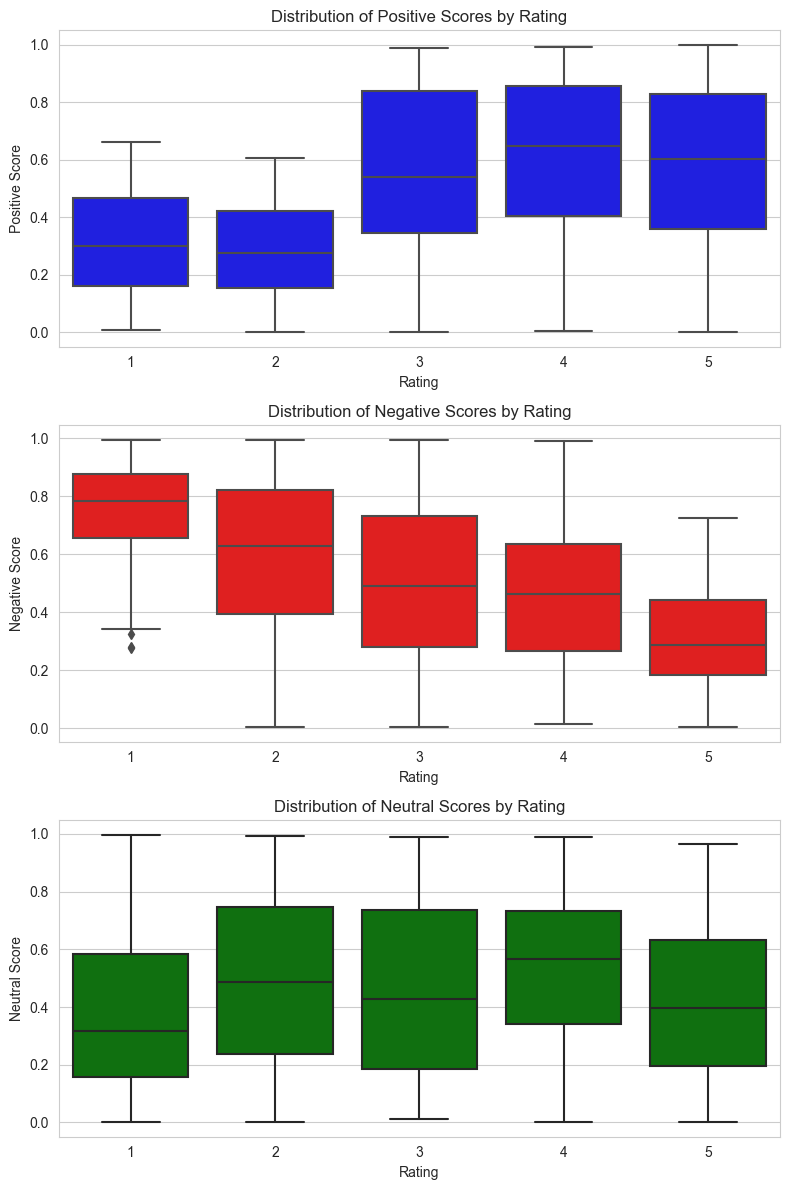

In [466]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Box plot for Positive Score
sns.boxplot(data=df, x='rating', y='s_positive', color='blue', ax=axes[0])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Positive Score')
axes[0].set_title('Distribution of Positive Scores by Rating')

# Box plot for Negative Score
sns.boxplot(data=df, x='rating', y='s_negative', color='red', ax=axes[1])
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Negative Score')
axes[1].set_title('Distribution of Negative Scores by Rating')

# Box plot for Neutral Score
sns.boxplot(data=df, x='rating', y='s_neutral', color='green', ax=axes[2])
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Neutral Score')
axes[2].set_title('Distribution of Neutral Scores by Rating')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

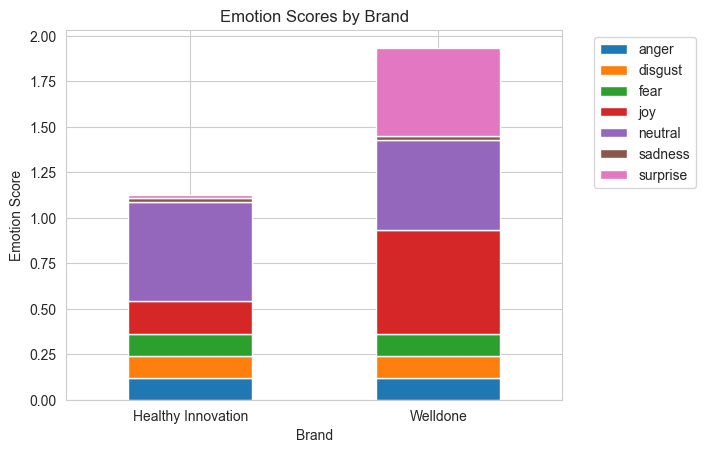

In [467]:
# Distribution of emotions
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df_emotions = df[emotions + ['brand']]

plt.figure(figsize=(10, 6))
df_emotions.groupby('brand')[emotions].mean().plot(kind='bar', stacked=True)
plt.xlabel('Brand')
plt.ylabel('Emotion Score')
plt.title('Emotion Scores by Brand')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Content analysis

In [489]:
df = pd.read_excel('abert_final_sentiment.xlsx')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('meat', 134), ('taste', 99), ('cutlets', 80), ('tasty', 79), ('like', 73), ('delicious', 70), ('Delicious', 55), ('good', 36), ('price', 35), ('eat', 32)]


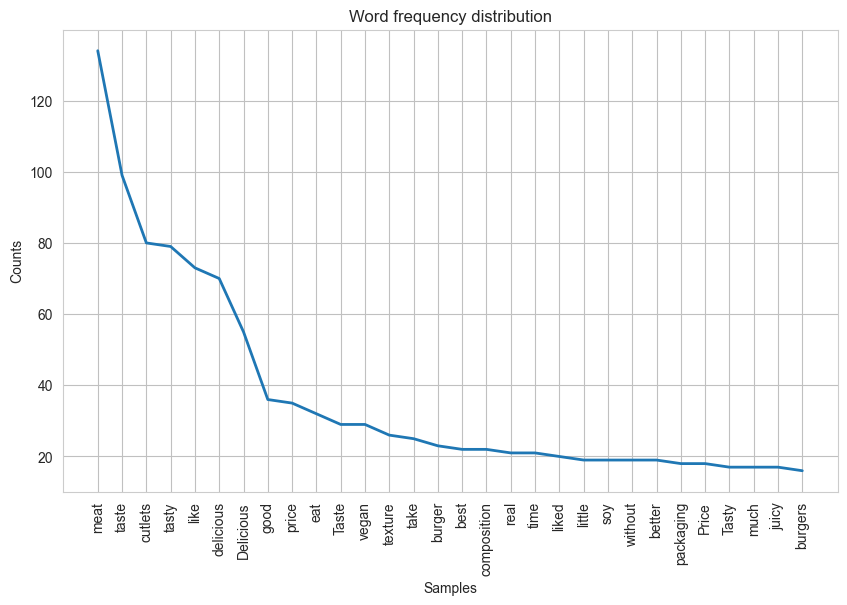

<Axes: title={'center': 'Word frequency distribution'}, xlabel='Samples', ylabel='Counts'>

In [490]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string

df['all_reviews'] = df['all_reviews'].fillna('')

# Download required resources (only required for the first time)
nltk.download('punkt')
nltk.download('stopwords')

# Define the text column you want to analyze
df['all_reviews'] = df['all_reviews'].fillna('')
text_column_name = 'all_reviews'

# Combine all text into a single string
corpus = ' '.join(df[text_column_name].dropna())

# Tokenize the text into individual words
tokens = word_tokenize(corpus)

# Remove stopwords (commonly used words without much meaning)
stop_words = set(stopwords.words('english'))
# Add custom stopwords
stop_words.update(['n\'t','\'s'])

filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Remove punctuation
filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]

# Calculate word frequencies
freq_dist = FreqDist(filtered_tokens)

# Print the most common words and their frequencies
print(freq_dist.most_common(10))

# Plot the word frequency distribution
plt.figure(figsize=(10, 6))
plt.title('Word frequency distribution')
freq_dist.plot(30, cumulative=False)

In [495]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models

# Download required resources (only required for the first time)
nltk.download('punkt')
nltk.download('stopwords')

# Define the text column you want to analyze
text_column_name = 'all_reviews'

# Preprocess the text data
df[text_column_name] = df[text_column_name].fillna('').astype(str)

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords.words('english') and token not in string.punctuation]
    tokens = [token for token in tokens if "n't" not in token and token != "'s"]
    return tokens

corpus = df[text_column_name].apply(preprocess_text)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(corpus)
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus]

# Perform Latent Dirichlet Allocation (LDA) topic modeling
num_topics = 5
lda_model = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=num_topics, random_state=42)

# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [501]:
# Remove stopwords from the text
text_without_stopwords = [word for word in text.split() if word.lower() not in stop_words]

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary([text_without_stopwords])
corpus = [dictionary.doc2bow(text_without_stopwords)]

# Run LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary)

# Create the LDA visualization
lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_visualization)

# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary([text_without_stopwords])
corpus = [dictionary.doc2bow(text_without_stopwords)]

# Run LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary)

# Visualize the topics
pyLDAvis.enable_notebook()

# Prepare the visualization
# `sort_topics=False` preserves the topic order in the LDA model.
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Show the visualization
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003546  0.000376       1        1  99.402309
1      0.000855 -0.002207       2        1   0.503847
2     -0.000229  0.001927       3        1   0.047587
3     -0.004480 -0.000214       4        1   0.005334
4      0.000307  0.000119       5        1   0.040922, topic_info=           Term       Freq      Total Category  logprob  loglift
1290      taste  64.000000  64.000000  Default  30.0000  30.0000
829        like  62.000000  62.000000  Default  29.0000  29.0000
872        meat  50.000000  50.000000  Default  28.0000  28.0000
500   delicious  43.000000  43.000000  Default  27.0000  27.0000
1297      tasty  38.000000  38.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
1337       time   0.004692  11.815121   Topic5  -5.8062  -0.0299
1203    similar   0.004739  12.386237   Topic5  -5.7963  -0.0672
831       liked   0.005002  16.753706   Topic5  -5.7423  -0.3153
377      burger   0.004811  14.269062   Topic5  -5.7812  -0.1936
222       Tasty   0.004671  14.081047   Topic5  -5.8107  -0.2099

[388 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
10        1  1.150297            't
24        1  0.796785          (the
27        1  0.940110             -
31        1  0.884546             /
46        1  0.919091           30,
...     ...       ...           ...
1406      1  1.082697  vegetarians,
1408      1  0.879862        velkam
1414      1  0.828190    vkusville,
1438      1  0.999766       without
1443      1  1.029454         would

[191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

c:\Users\celin\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


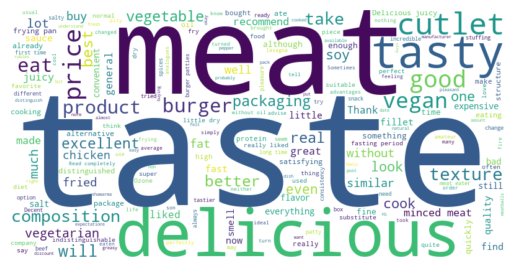

In [497]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

df['all_reviews'] = df['all_reviews'].fillna('')

# Creating a text variable with all reviews
text = " ".join(review for review in df.all_reviews)

# Creating a list of stopwords
stopwords = set(STOPWORDS)

# Generating the word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)


# Displaying the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Hypotheses testing

In [477]:
df = pd.read_excel('abert_final_sentiment.xlsx')

In [471]:
from scipy.stats import shapiro, levene
from tabulate import tabulate

# Check normality assumption
_, p_value1 = shapiro(df['neutral'])
_, p_value2 = shapiro(df['joy'])

# Check equal variance assumption
_, p_value3 = levene(df['neutral'], df['joy'])

# Create table data
table_data = [
    ["Normality Test", "Neutral Attitudes", p_value1],
    ["Normality Test", "Joy Attitudes", p_value2],
    ["Equal Variance Test", "Levene's Test", p_value3]
]

# Generate table
table = tabulate(table_data, headers=["Test", "Variable", "p-value"], tablefmt="pipe")

# Print table
print(table)

| Test                | Variable          |     p-value |
|:--------------------|:------------------|------------:|
| Normality Test      | Neutral Attitudes | 1.61035e-34 |
| Normality Test      | Joy Attitudes     | 4.2024e-34  |
| Equal Variance Test | Levene's Test     | 1.46396e-63 |


In [485]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(df['neutral'][df['brand'] == 'Welldone'], alternative='greater')

# Print the test statistics and p-value
print("Wilcoxon Signed-Rank Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("H1 is supported: The presence of informational appeal in advertisements positively influences neutral attitudes.")
else:
    print("H1 is not supported.")

Wilcoxon Signed-Rank Test:
Statistic: 63903.0
P-value: 5.557497944457779e-66
H1 is supported: The presence of informational appeal in advertisements positively influences neutral attitudes.


In [358]:
#H2: The presence of emotional appeal in advertisements will positively influence the perception of positive attitudes towards the ad.
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(df['joy'][df['brand'] == 'Welldone'], alternative='greater')

# Check the p-value
if p_value < 0.05:
    print("H2 is supported: The presence of emotional appeal in advertisements positively influences positive attitudes.")
else:
    print("H2 is not supported.")

H2 is supported: The presence of emotional appeal in advertisements positively influences positive attitudes.


In [359]:
# H3: The effectiveness of an informational message will be enhanced when combined with a sensory appeal rather than nutrient-content claims.
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(df['neutral'][df['brand'] == 'Welldone'],
                                 df['neutral'][df['brand'] == 'Healthy Innovation'],
                                 alternative='greater')

# Check the p-value
if p_value < 0.05:
    print("H3 is supported: The effectiveness of an informational message is enhanced when combined with a sensory appeal.")
else:
    print("H3 is not supported.")


H3 is not supported.


In [360]:
# H4: The effectiveness of an emotional message will be enhanced when combined with nutrient-content claims rather than sensory appeal.
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(df['joy'][df['brand'] == 'Welldone'],
                                 df['joy'][df['brand'] == 'Healthy Innovation'],
                                 alternative='greater')

# Check the p-value
if p_value < 0.05:
    print("H4 is supported: The effectiveness of an emotional message is enhanced when combined with nutrient-content claims.")
else:
    print("H4 is not supported.")


H4 is supported: The effectiveness of an emotional message is enhanced when combined with nutrient-content claims.
